C:\Users\THINK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


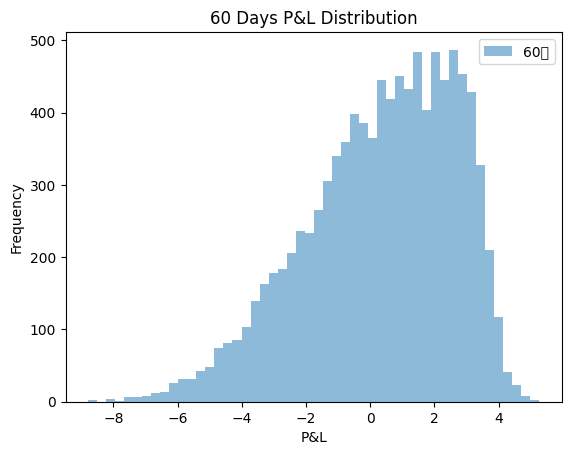

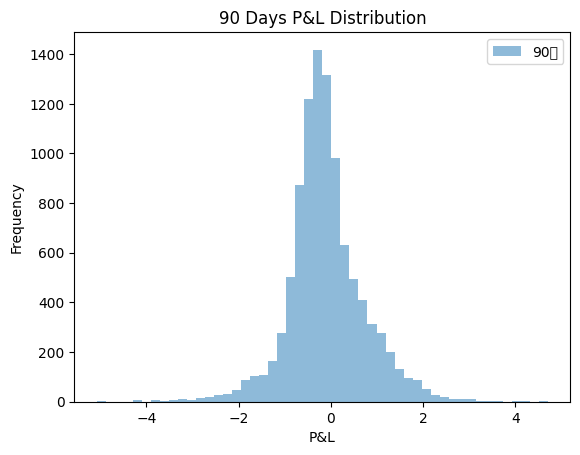

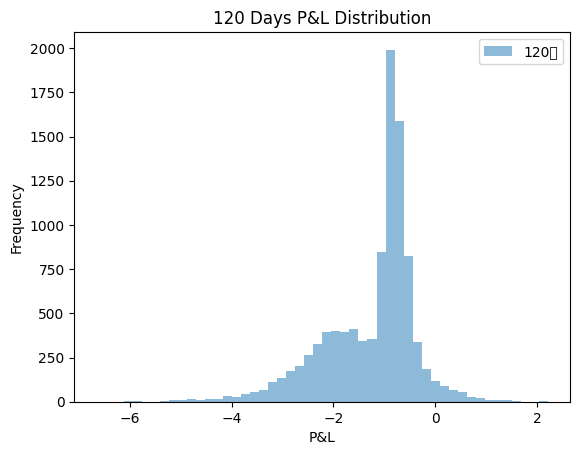

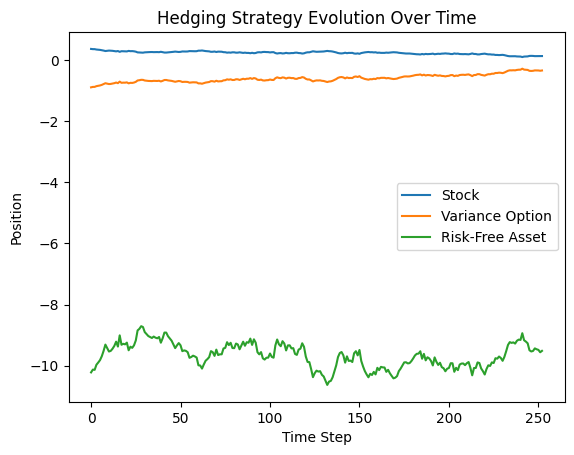

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 设置随机种子以确保结果可重复
np.random.seed(42)
torch.manual_seed(42)

# 模型参数
S0 = 100  
v0 = 0.04  
lambda_ = -1.5
theta = 0.04 
kappa = 2 
sigma = 0.3
rho = -0.7 
r = 0.01 
K = 100  
Kv = 0.04  
c = 0.003  
T = 1.0 
N = 253 
dt = T / N 

# 模拟路径数量
num_paths = 10000

# 5.1.1 市场模拟（Heston模型）
def simulate_heston_paths(S0, v0, T, N, num_paths, params):
    kappa, theta, sigma, rho, r, lambda_ = params

    # 调整参数以适应风险中性测度
    kappa_Q = kappa + lambda_ * sigma
    theta_Q = theta

    S = np.zeros((num_paths, N + 1))
    v = np.zeros((num_paths, N + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    # 生成相关布朗运动
    Z1 = np.random.normal(0, np.sqrt(dt), size=(num_paths, N))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), size=(num_paths, N))

    for t in range(N):
        v_t = v[:, t]
        S_t = S[:, t]

        dv = kappa_Q * (theta_Q - v_t) * dt + sigma * np.sqrt(np.maximum(v_t, 0)) * Z2[:, t]
        v[:, t + 1] = np.maximum(v_t + dv, 0)  
    
        dS = r * S_t * dt + np.sqrt(np.maximum(v_t, 0)) * S_t * Z1[:, t]
        S[:, t + 1] = S_t + dS

    return S, v

params = (kappa, theta, sigma, rho, r, lambda_)
S_paths, v_paths = simulate_heston_paths(S0, v0, T, N, num_paths, params)
integrated_variance = np.zeros((num_paths, N + 1))
for i in range(num_paths):
    integrated_variance[i, 1:] = np.cumsum(v_paths[i, :-1] * dt)

# 5.1.2 方差期权定价（Longstaff-Schwartz方法）
def price_variance_option(S_paths, v_paths, r, T, N, K):
    dt = T / N
    option_values = np.zeros((num_paths, N + 1))
    times = np.linspace(0, T, N + 1)

    for t in range(N - 1, -1, -1):
        if t < N - 1:
            v_t = v_paths[:, t:-1]
            v_next = v_paths[:, t + 1:]
            min_len = min(v_t.shape[1], v_next.shape[1])
            approx_remaining = np.sum(0.5 * (v_t[:, :min_len] + v_next[:, :min_len]) * dt, axis=1)
        else:
            approx_remaining = np.sum(0.5 * (v_paths[:, t:] + v_paths[:, t + 1:]) * dt, axis=1)
        if t == N - 1:
            payoff = np.maximum(approx_remaining - K, 0)
            option_values[:, t] = np.exp(-r * (T - times[t])) * payoff
        else:
            itm = approx_remaining > K
            if np.sum(itm) > 0:
                X = np.vstack([
                    np.ones(np.sum(itm)),  
                    v_paths[itm, t],  
                    v_paths[itm, t]**2,  
                    integrated_variance[itm, t],  
                    S_paths[itm, t], 
                    S_paths[itm, t] * v_paths[itm, t] 
                ]).T

                y = option_values[itm, t + 1] * np.exp(-r * dt)  

                beta = np.linalg.lstsq(X, y, rcond=None)[0]
                option_values[itm, t] = np.dot(X, beta)
            else:
                option_values[:, t] = 0

    return option_values

variance_option_prices = price_variance_option(S_paths, v_paths, r, T, N, Kv)

# 5.1.3 神经网络训练和测试
class PathDataset(Dataset):
    def __init__(self, S_paths, v_paths, option_prices):
        self.S = torch.FloatTensor(S_paths)
        self.v = torch.FloatTensor(v_paths)
        self.option = torch.FloatTensor(option_prices)
    
    def __len__(self):
        return self.S.shape[0]
    
    def __getitem__(self, idx):
        return self.S[idx], self.v[idx], self.option[idx]

class HedgingNet(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=3):
        super(HedgingNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 训练和测试
training_periods = [60, 90, 120]
results = {}

for period in training_periods:
    dataset = PathDataset(S_paths[:, :period + 1], v_paths[:, :period + 1], variance_option_prices[:, :period + 1])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = HedgingNet(input_size=3, hidden_size=64, output_size=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(100):
        for S_batch, v_batch, option_batch in dataloader:
            batch_size = S_batch.size(0)
            N_train = S_batch.size(1) - 1
            times = torch.arange(N_train, dtype=torch.float32) / N_train
            times = times.view(-1, 1).repeat(1, batch_size).view(N_train, batch_size)
            S_batch_t = S_batch[:, :N_train].T
            v_batch_t = v_batch[:, :N_train].T
            state = torch.stack([times, S_batch_t, v_batch_t], dim=2)  # (N_train, batch_size, 3)
            state_flat = state.view(-1, 3)
            positions_flat = model(state_flat)
            positions = positions_flat.view(N_train, batch_size, 3)

            asset_prices_list = []
            for t in range(N_train):
                B_t = torch.exp(torch.tensor(r * t * dt, dtype=torch.float32)) * torch.ones(batch_size)
                asset_prices_t = torch.stack([S_batch[:, t], option_batch[:, t], B_t], dim=1)
                asset_prices_list.append(asset_prices_t)
            asset_prices = torch.stack(asset_prices_list, dim=0)  # (N_train, batch_size, 3)

            positions_shifted = torch.cat([torch.zeros(1, batch_size, 3), positions[:-1]], dim=0)
            trade = torch.abs(positions - positions_shifted)
            transaction_costs = c * trade * asset_prices
            cumulative_transaction_costs = transaction_costs.sum(dim=2).sum(dim=0)

            B_T = torch.exp(torch.tensor(r * T, dtype=torch.float32)) * torch.ones(batch_size)
            asset_prices_T = torch.stack([S_batch[:, N_train], option_batch[:, N_train], B_T], dim=1)
            P_T = (positions[-1] * asset_prices_T).sum(dim=1) - cumulative_transaction_costs
            payoff_T = torch.max(S_batch[:, N_train] - K, torch.zeros(batch_size))
            P_and_L = P_T - payoff_T
            loss = ((P_and_L)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 测试并计算P&L
    with torch.no_grad():
        S_test = torch.FloatTensor(S_paths[:, :period + 1])
        v_test = torch.FloatTensor(v_paths[:, :period + 1])
        option_test = torch.FloatTensor(variance_option_prices[:, :period + 1])
        N_test = S_test.size(1) - 1
        times = torch.arange(N_test, dtype=torch.float32) / N_test
        times = times.view(-1, 1).repeat(1, num_paths).view(N_test, num_paths)
        S_test_t = S_test[:, :N_test].T
        v_test_t = v_test[:, :N_test].T
        state = torch.stack([times, S_test_t, v_test_t], dim=2)
        state_flat = state.view(-1, 3)
        positions_flat = model(state_flat)
        positions = positions_flat.view(N_test, num_paths, 3)

        asset_prices_list = []
        for t in range(N_test):
            B_t = torch.exp(torch.tensor(r * t * dt, dtype=torch.float32)) * torch.ones(num_paths)
            asset_prices_t = torch.stack([S_test[:, t], option_test[:, t], B_t], dim=1)
            asset_prices_list.append(asset_prices_t)
        asset_prices = torch.stack(asset_prices_list, dim=0)

        positions_shifted = torch.cat([torch.zeros(1, num_paths, 3), positions[:-1]], dim=0)
        trade = torch.abs(positions - positions_shifted)
        transaction_costs = c * trade * asset_prices
        cumulative_transaction_costs = transaction_costs.sum(dim=2).sum(dim=0)

        B_T = torch.exp(torch.tensor(r * T, dtype=torch.float32)) * torch.ones(num_paths)
        asset_prices_T = torch.stack([S_test[:, N_test], option_test[:, N_test], B_T], dim=1)
        P_T = (positions[-1] * asset_prices_T).sum(dim=1) - cumulative_transaction_costs
        payoff_T = torch.max(S_test[:, N_test] - K, torch.zeros(num_paths))
        P_and_L = P_T - payoff_T

        results[period] = P_and_L.numpy()

        # 绘制P&L分布直方图
        plt.hist(P_and_L.numpy(), bins=50, alpha=0.5, label=f'{period}天')
        plt.legend()
        plt.title(f'{period} Days P&L Distribution')
        plt.xlabel('P&L')
        plt.ylabel('Frequency')
        plt.show()

random_path = np.random.randint(0, num_paths)
with torch.no_grad():
    test_S = torch.FloatTensor(S_paths[random_path:random_path+1])
    test_v = torch.FloatTensor(v_paths[random_path:random_path+1])
    test_option = torch.FloatTensor(variance_option_prices[random_path:random_path+1])
    N_test = test_S.size(1) - 1
    times = torch.arange(N_test, dtype=torch.float32) / N_test
    times = times.view(-1, 1).repeat(1, 1).view(N_test, 1)
    S_test_t = test_S[:, :N_test].T
    v_test_t = test_v[:, :N_test].T
    state = torch.stack([times, S_test_t, v_test_t], dim=2)
    state_flat = state.view(-1, 3)
    positions = model(state_flat).view(N_test, 3)

    plt.plot(range(N_test), positions.numpy())
    plt.legend(['Stock', 'Variance Option', 'Risk-Free Asset'])
    plt.title('Hedging Strategy Evolution Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.show()

### Impact of Transaction Costs  
Transaction costs are set at 0.3% (\(c = 0.003\)) in the strategy, deducted from the final portfolio value \(P_T\) through cumulative transaction costs. The analysis is based on the P&L distributions:

- **60 Days P&L**:  
 Transaction costs likely contribute to negative P&L, especially during frequent trading, such as risk-free asset adjustments.

- **90 Days P&L**:  
Compared to 60 days, the distribution is more concentrated, suggesting a 90-day training period better mitigates transaction costs, reducing extreme losses.

- **120 Days P&L Distribution**:  
 With a longer training period, the P&L distribution is tighter, with a more positive mean, indicating improved strategy optimization and reduced transaction cost impact.

### Role of Variance Options  
 Variance options play a critical role in stabilizing volatility risk hedging, reducing P&L fluctuations, particularly with extended training periods. Their positions align with stocks, showing effective design utilization.

### Comparison of Theoretical and Deep Hedging  
Deep hedging outperforms theoretical hedging in real markets by accounting for transaction costs, achieving near-zero mean P&L. The strategy evolution plot shows stable positions that minimize trading, while theoretical hedging is efficient in ideal conditions but less practical due to high costs.

### Potential Improvements  
Despite strong performance, improvements are possible:  
- **Additional Features**: Incorporate historical returns or other market indicators to enhance model predictions.  
- **More Data**: Increase simulated paths or extend training periods (e.g., 180 days) for better generalization.  
- **Hyperparameter Tuning**: Optimize learning rate, batch size, etc., to improve convergence.  
- **Real Market Data**: Train with actual market data for enhanced applicability.